In [1]:
#@title Import Dependencies

import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import math

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# #@title What gpu?
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Not connected to a GPU')
# else:
#   print(gpu_info)

In [4]:
class Net(nn.Module):
  def __init__(self, EP_size, LHB_size, DAN_size):
    super(Net,self).__init__()
    self.EP_to_LHb = nn.Linear(EP_size, LHB_size, bias=True)
    # nn.init.xavier_normal_(self.EP_to_LHb.weight)

    self.LHb_to_DAN = nn.Linear(LHB_size, DAN_size, bias=True)
    # nn.init.xavier_normal_(self.LHb_to_DAN.weight)
    
    with torch.no_grad():
      self.LHb_to_DAN.weight.data=-torch.sign(self.LHb_to_DAN.weight)*self.LHb_to_DAN.weight/5 # all -
    
    self.relu = nn.ReLU()
    self.tanh = nn.Tanh()

  # def initWeights(self):
  #   with torch.no_grad():
  #     self.LHb_to_DAN.weight.data=-torch.sign(self.LHb_to_DAN.weight)*self.LHb_to_DAN.weight/5 # all -

  def trimWeights(self):
    with torch.no_grad():
      self.LHb_to_DAN.weight.data=torch.minimum(self.LHb_to_DAN.weight, 0*self.LHb_to_DAN.weight) # all -

  def forward(self, input):
    LHB_act = self.EP_to_LHb(input)
    LHB_out = self.tanh(LHB_act)

    DAN_act = self.LHb_to_DAN(LHB_out)
    DAN_out = self.tanh(DAN_act)

    return DAN_out

In [5]:
class adam(torch.optim.Optimizer): 
	def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, fixed_sign: bool = False): 
		defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, fixed_sign=fixed_sign)
		super(adam, self).__init__(params, defaults) 

	def step(self, init_weights=None): 
		for group in self.param_groups: 
			for i, p in enumerate(group['params']): 
				if p.grad is None: 
					continue
				grad = p.grad.data 
				if grad.is_sparse: 
					raise RuntimeError("Adam does not support sparse gradients") 

				state = self.state[p] 

				# State initialization 
				if len(state) == 0: 
					state["step"] = 0
					# Momentum: Exponential moving average of gradient values 
					state["exp_avg"] = torch.zeros_like(p.data) 
					# RMS prop componenet: Exponential moving average of squared gradient values 
					state["exp_avg_sq"] = torch.zeros_like(p.data) 

				exp_avg, exp_avg_sq = state["exp_avg"], state["exp_avg_sq"] 
				beta1, beta2 = group["betas"] 
				state["step"] += 1

				if group['weight_decay'] != 0: 
					grad = grad.add(p.data, alpha=group['weight_decay']) 

				# Decay the first and second moment running average coefficient
				exp_avg.lerp_(grad, 1 - beta1) # momentum
				exp_avg_sq.mul_(beta2).addcmul_(grad, grad.conj(), value=1-beta2) # rms
			
				bias_correction1 = 1 - beta1 ** state["step"] 
				bias_correction2 = 1 - beta2 ** state["step"] 

				step_size = group["lr"] / bias_correction1
				bias_correction2_sqrt = math.sqrt(bias_correction2)

				denom = (exp_avg_sq.sqrt() / bias_correction2_sqrt).add_(group["eps"])

				p.data.addcdiv_(exp_avg, denom, value=-step_size)
				
				if group["fixed_sign"]: 
					if init_weights is None: ValueError('Need to provide initial weights if fixed_sign is true!')
					flip_mask = init_weights[i].sign()*p.data.sign()<0
					p.data[flip_mask] = 0

In [6]:
#@title Define Hyperparameters

EP_size = 300 # there are this many inputs that represent features and set to -1, 0, 1
LHB_size = 100 # number of neurons in the LHB that receive EP input
DAN_size = 1 # how DANs to calculate value
batch_size = 200 # the size of input data took for one iteration
num_epochs = 50
lr = 1e-2 # size of step

In [7]:
#@title Generate the data

prob_input_active = 0.05 # probability that an input is active in each context
prob_output_active = 0.125
n_contexts = 5000

rands = torch.rand(n_contexts, EP_size, device=device)
train_data = 1.0*(rands<prob_input_active) - 1.0*(rands>(1-prob_input_active))
rands = torch.rand(n_contexts, device=device)
# train_labels = 2*rands-1
train_labels = 1.0*(rands<prob_output_active) - 1.0*(rands>(1-prob_output_active))
# train_labels = torch.transpose(train_labels.repeat(DAN_size, 1), 0, 1)

rands = torch.rand(n_contexts, EP_size, device=device)
test_data = 1.0*(rands<prob_input_active) - 1.0*(rands>(1-prob_input_active))
rands = torch.rand(n_contexts, device=device)
# test_labels = 2*rands-1
test_labels = 1.0*(rands<prob_output_active) - 1.0*(rands>(1-prob_output_active))
# test_labels = torch.transpose(test_labels.repeat(DAN_size, 1), 0, 1)

Text(0.5, 1.0, 'Test labels')

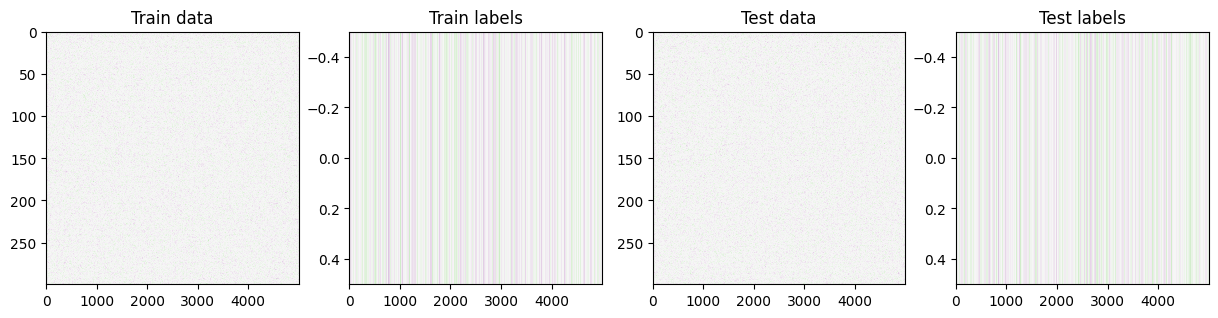

In [8]:
# Plot training data and label

fig, axs = plt.subplots(1,4, figsize=(15,5))

im = axs[0].imshow(torch.t(train_data), cmap='PRGn', aspect=train_data.shape[0]/train_data.shape[1])
# plt.colorbar(im)
axs[0].set_title('Train data')

im = axs[1].imshow(train_labels[None], cmap='PRGn', aspect=train_labels.shape[0])
# plt.colorbar(im)
axs[1].set_title('Train labels')

im = axs[2].imshow(torch.t(test_data), cmap='PRGn', aspect=test_data.shape[0]/test_data.shape[1])
# plt.colorbar(im)
axs[2].set_title('Test data')

im = axs[3].imshow(test_labels[None], cmap='PRGn', aspect=test_labels.shape[0])
# plt.colorbar(im)
axs[3].set_title('Test labels')

In [9]:
# #@title function to plot an image with the scale color bar
# def plotWithColor(data):
#   if torch.is_tensor(data):
#     data=data.cpu().numpy()
#   ax = plt.subplot()
#   im = ax.imshow(data)
#   divider = make_axes_locatable(ax)
#   cax = divider.append_axes("right", size="5%", pad=0.05)

#   plt.colorbar(im, cax=cax)

#   plt.show()


In [10]:
# plotWithColor(training)
# plt.plot(training_labels.cpu(), '.')
# #plotWithColor(training_labels)
# training.size(), training_labels.size()

In [11]:
# #@title Define model class

# class Net(nn.Module):
#   def __init__(self):
#     super(Net,self).__init__()
#     self.EP_to_LHB = nn.Linear(EP_size, LHB_size, bias=True) # this will be all positive weights
#     self.LHB_to_DAN = nn.Linear(LHB_size, DAN_size, bias=True) # this will be all positive weights
#     self.relu = nn.ReLU()
#     self.tanh = nn.Tanh()

#     with torch.no_grad():
#        self.LHB_to_DAN.weight.data=-torch.sign(self.LHB_to_DAN.weight)*self.LHB_to_DAN.weight/5 # all -

#   # def initWeights(self):
#   #   with torch.no_grad():
#   #      self.LHB_to_DAN.weight.data=-torch.sign(self.LHB_to_DAN.weight)*self.LHB_to_DAN.weight/5 # all -

#   def trimWeights(self):
#     with torch.no_grad():
#       self.LHB_to_DAN.weight.data=torch.minimum(self.LHB_to_DAN.weight, 0*self.LHB_to_DAN.weight) # all -

#   def forward(self, input):
#     LHB_act = self.EP_to_LHB(input)
#     LHB_out = self.tanh(LHB_act)

#     DAN_act = self.LHB_to_DAN(LHB_out)
#     DAN_out = self.tanh(DAN_act)

#     return DAN_out

In [12]:
# net = Net()
net = Net(EP_size,LHB_size,DAN_size)
if torch.cuda.is_available():
  net.cuda()

# Define loss-function & optimizer
loss_function = nn.MSELoss()
optimizer = adam(net.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
training_loss = []

EP_to_LHb.weight
 Positive: 49.996668100357056%; Negative: 50.003331899642944%; Zero: 0.0%
EP_to_LHb.bias
 Positive: 56.99999928474426%; Negative: 43.00000071525574%; Zero: 0.0%
LHb_to_DAN.weight
 Positive: 0.0%; Negative: 100.0%; Zero: 0.0%
LHb_to_DAN.bias
 Positive: 0.0%; Negative: 100.0%; Zero: 0.0%


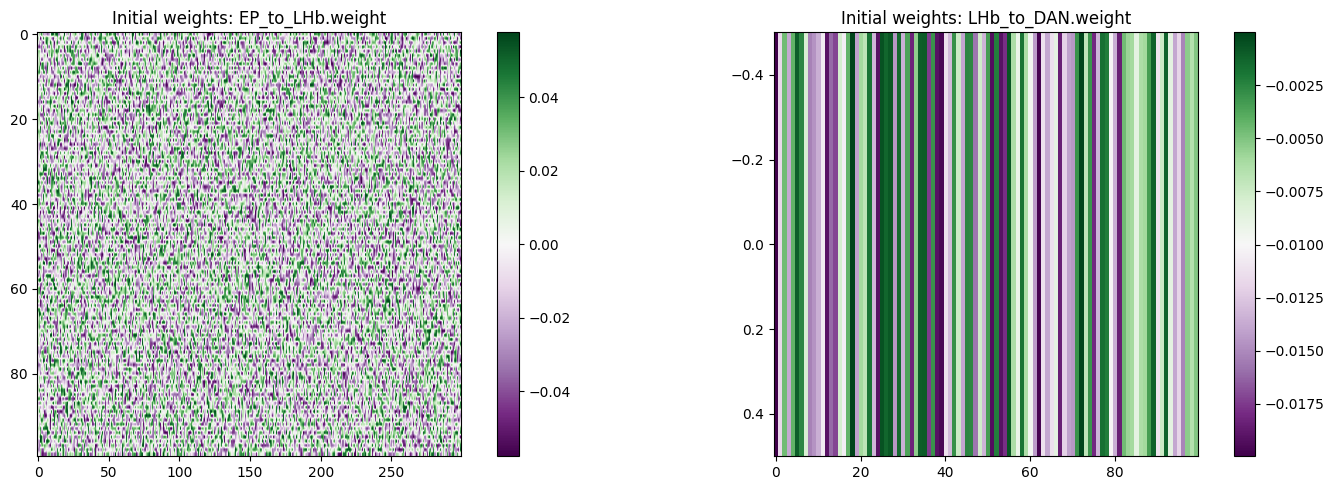

In [13]:
# Save the initial weights
initial_params_corelease = {}
for name, param in net.named_parameters():
    if param.requires_grad:
      print(name)
      with torch.no_grad():
        cur_data = param.data.detach().cpu().clone()
        initial_params_corelease[name] = (cur_data)
      
      frac_pos = 100*(torch.sum(cur_data > 0)/cur_data.numel()).numpy()
      frac_zero = 100*(torch.sum(cur_data == 0)/cur_data.numel()).numpy()
      frac_neg = 100*(torch.sum(cur_data < 0)/cur_data.numel()).numpy()
      print(' Positive: ' + str(frac_pos) + '%; Negative: ' + str(frac_neg) + '%; Zero: ' + str(frac_zero) + '%')

# Plot initialized weights
fig, axs = plt.subplots(1,int(len(initial_params_corelease)/2),figsize=(15, 5))
plt.subplots_adjust(hspace=0.5)

ax = 0
for key, value in initial_params_corelease.items():
    if "bias" in key: continue
    im = axs[ax].imshow(value.numpy(), cmap='PRGn', aspect=value.shape[1]/value.shape[0])
    axs[ax].set_title('Initial weights: ' + key)
    plt.colorbar(im)
    ax += 1

plt.tight_layout()
plt.show()

Epoch [1/50], Step [25/1], Loss: 0.2269
Epoch [2/50], Step [25/1], Loss: 0.2321
Epoch [3/50], Step [25/1], Loss: 0.2200
Epoch [4/50], Step [25/1], Loss: 0.2150
Epoch [5/50], Step [25/1], Loss: 0.2141
Epoch [6/50], Step [25/1], Loss: 0.2807
Epoch [7/50], Step [25/1], Loss: 0.2093
Epoch [8/50], Step [25/1], Loss: 0.2139
Epoch [9/50], Step [25/1], Loss: 0.2185
Epoch [10/50], Step [25/1], Loss: 0.2154
Epoch [11/50], Step [25/1], Loss: 0.2374
Epoch [12/50], Step [25/1], Loss: 0.2092
Epoch [13/50], Step [25/1], Loss: 0.2073
Epoch [14/50], Step [25/1], Loss: 0.2142
Epoch [15/50], Step [25/1], Loss: 0.2034
Epoch [16/50], Step [25/1], Loss: 0.1742
Epoch [17/50], Step [25/1], Loss: 0.1663
Epoch [18/50], Step [25/1], Loss: 0.1404
Epoch [19/50], Step [25/1], Loss: 0.1170
Epoch [20/50], Step [25/1], Loss: 0.0968
Epoch [21/50], Step [25/1], Loss: 0.0799
Epoch [22/50], Step [25/1], Loss: 0.0670
Epoch [23/50], Step [25/1], Loss: 0.0566
Epoch [24/50], Step [25/1], Loss: 0.0479
Epoch [25/50], Step [25/1

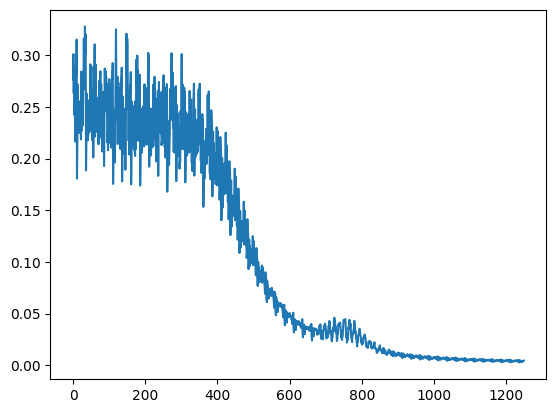

In [14]:
#@title Training the model
for epoch in range(num_epochs):
  for counter in range(max(1, math.floor(n_contexts/batch_size))):
    batch_range = range(counter*batch_size, counter*batch_size+batch_size)
    batch_data = train_data[batch_range,:]#.cuda()
    batch_labels = train_labels[batch_range]#.cuda()

    optimizer.zero_grad()
    outputs = net(batch_data)
    
    loss = loss_function(outputs.flatten(), batch_labels)
    training_loss.append(loss.data.cpu())

    loss.backward()
    optimizer.step()
    net.trimWeights()
    
  print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
              %(epoch+1, num_epochs, counter+1, len(batch_data)//batch_size, loss.data))
  scheduler.step()

# Plot training loss
plt.plot(training_loss)

Text(0.5, 1.0, 'Accuracy: 0.0200 %')

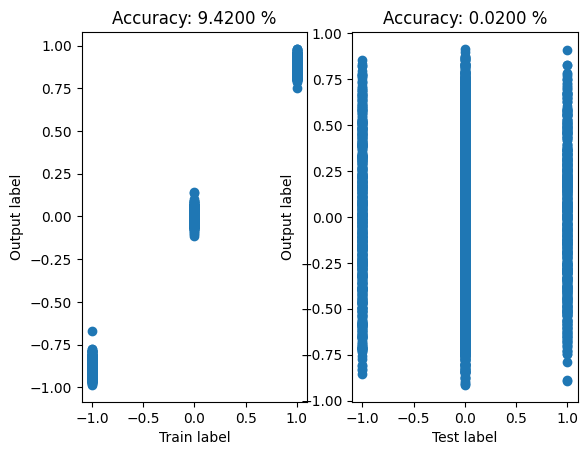

In [16]:
#@title Evaluating the accuracy of the model
with torch.no_grad():
  train_outputs = net(train_data)
  test_outputs = net(test_data)

  # Calculate accuracy
  train_accuracy = 100 * (torch.isclose(train_outputs.squeeze(), train_labels, rtol=1e-1)).sum() / train_labels.shape[0]
  test_accuracy = 100 * (torch.isclose(test_outputs.squeeze(), test_labels, rtol=1e-1)).sum() / test_labels.shape[0]

fig, axs = plt.subplots(1,2)

axs[0].plot(train_labels.flatten().cpu().numpy(), train_outputs.flatten().cpu().numpy(), 'o')
axs[0].set_xlabel('Train label')
axs[0].set_ylabel('Output label')
axs[0].set_title('Accuracy: %.4f %%' %(train_accuracy))

axs[1].plot(test_labels.flatten().cpu().numpy(), test_outputs.flatten().cpu().numpy(), 'o')
axs[1].set_xlabel('Test label')
axs[1].set_ylabel('Output label')
axs[1].set_title('Accuracy: %.4f %%' %(test_accuracy))

EP_to_LHb.weight
 Positive: 50.42666792869568%; Negative: 49.57333207130432%; Zero: 0.0%
EP_to_LHb.bias
 Positive: 55.000001192092896%; Negative: 44.999998807907104%; Zero: 0.0%
LHb_to_DAN.weight
 Positive: 0.0%; Negative: 100.0%; Zero: 0.0%
LHb_to_DAN.bias
 Positive: 0.0%; Negative: 100.0%; Zero: 0.0%


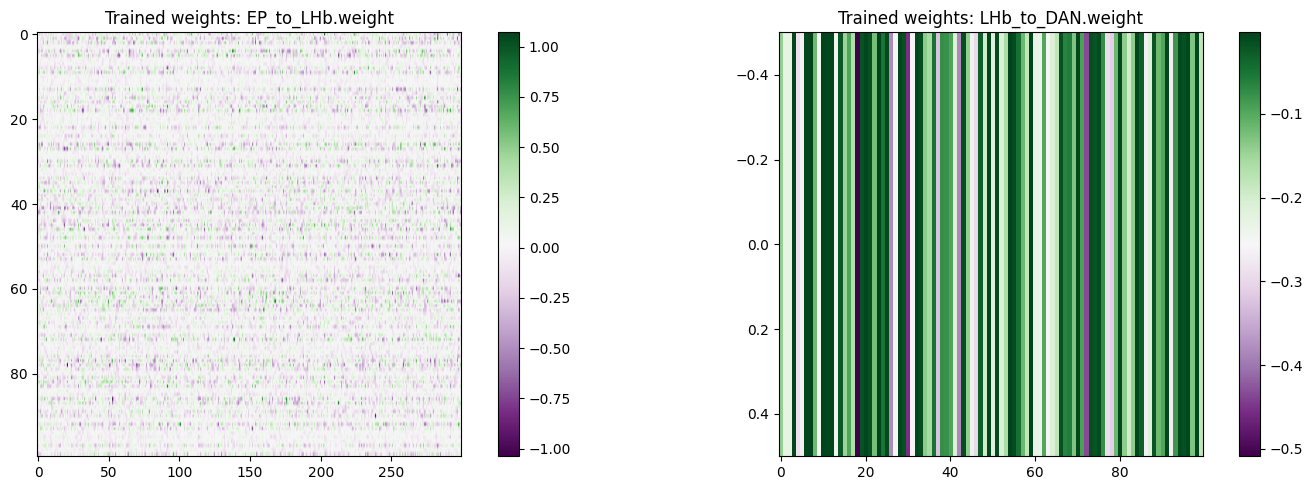

In [17]:
# Save the trianed parameters in paramList

trained_params_corelease = {}
for name, param in net.named_parameters():
    if param.requires_grad:
      print(name)
      with torch.no_grad():
        cur_data = param.data.detach().cpu().clone()
        trained_params_corelease[name] = (cur_data)
      
      frac_pos = 100*(torch.sum(cur_data > 0)/cur_data.numel()).numpy()
      frac_zero = 100*(torch.sum(cur_data == 0)/cur_data.numel()).numpy()
      frac_neg = 100*(torch.sum(cur_data < 0)/cur_data.numel()).numpy()
      print(' Positive: ' + str(frac_pos) + '%; Negative: ' + str(frac_neg) + '%; Zero: ' + str(frac_zero) + '%')

# Plot initialized weights
fig, axs = plt.subplots(1,int(len(trained_params_corelease)/2),figsize=(15, 5))
plt.subplots_adjust(hspace=0.5)

ax = 0
for key, value in trained_params_corelease.items():
    if "bias" in key: continue
    im = axs[ax].imshow(value.numpy(), cmap='PRGn', aspect=value.shape[1]/value.shape[0])
    axs[ax].set_title('Trained weights: ' + key)
    plt.colorbar(im)
    ax += 1

plt.tight_layout()
plt.show()

EP_to_LHb.weight flipped:  28.283% (8485/30000)
EP_to_LHb.bias flipped:  28.000% (28/100)
LHb_to_DAN.weight flipped:  0.000% (0/100)
LHb_to_DAN.bias flipped:  0.000% (0/1)
EP_to_LHb.weight changed:  100.000% (30000/30000)
EP_to_LHb.bias changed:  100.000% (100/100)
LHb_to_DAN.weight changed:  100.000% (100/100)
LHb_to_DAN.bias changed:  100.000% (1/1)


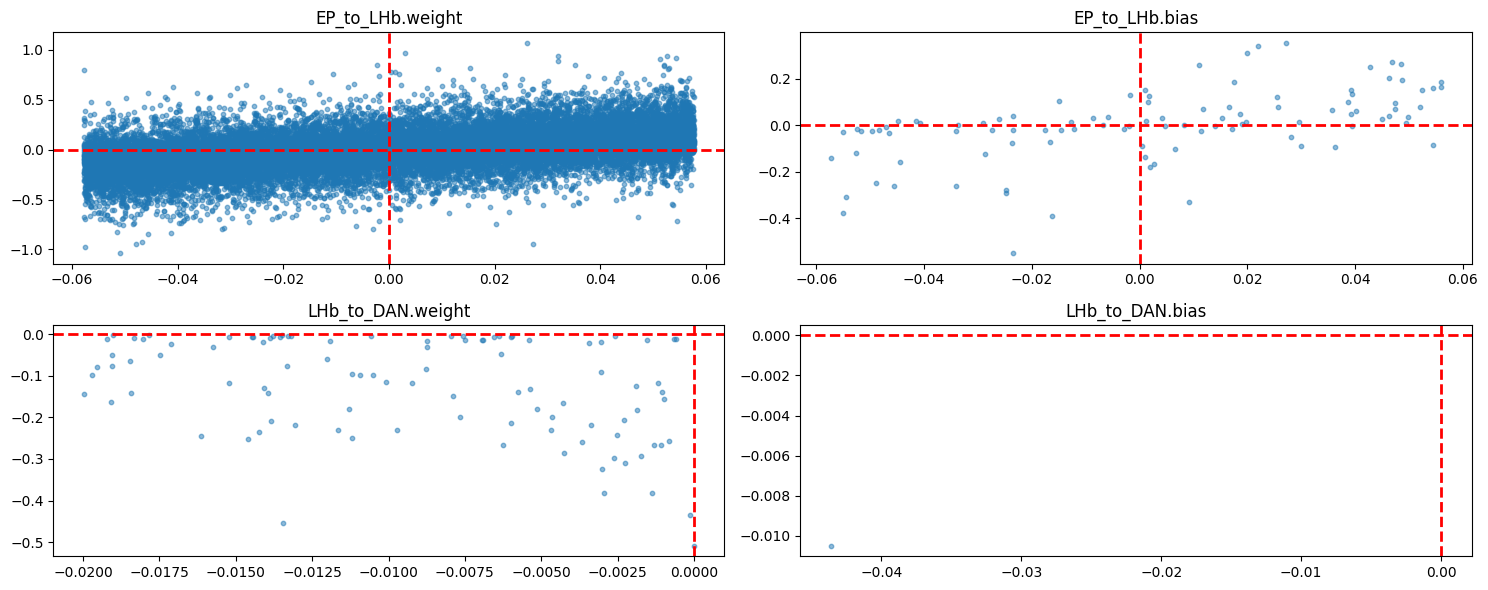

In [18]:
#@title What fraction of parameters flip sign?
for key in initial_params_corelease:
    n_weights=initial_params_corelease[key].numel()
    n_flip = (initial_params_corelease[key].sign()*trained_params_corelease[key].sign()<0).count_nonzero().item()
    print(key + ' flipped: % .3f%% (%d/%d)' %(100*n_flip/n_weights, n_flip, n_weights))

for key in initial_params_corelease:
    n_weights=initial_params_corelease[key].numel()
    n_changed = (initial_params_corelease[key] != trained_params_corelease[key]).count_nonzero().item()
    print(key + ' changed: % .3f%% (%d/%d)' %(100*n_changed/n_weights, n_changed, n_weights))

# Plot initial vs trained values

fig, axs = plt.subplots(2,int(len(trained_params_corelease)/2),figsize=(15, 6))
plt.subplots_adjust(hspace=0.5)

ax = 0
for i, ax in enumerate(axs.flatten()):
    key = list(initial_params_corelease)[i]
    ax.scatter(initial_params_corelease[key].numpy(),trained_params_corelease[key].numpy(),s=10,alpha=0.5)
    ax.axhline(y=0, linewidth=2, color = 'r', ls='--')
    ax.axvline(x=0, linewidth=2, color = 'r', ls='--')
    ax.set_title(key)

plt.tight_layout()
plt.show()

In [19]:
#@title Generate the data

prob_output_flip = 0.5

# flip_mask = torch.rand(n_contexts, device=device) < prob_output_flip
# train_labels_flipped = train_labels.clone()
# train_labels_flipped[flip_mask] *= -1

nonzero_idx = train_labels.nonzero()
flip_mask_nonzero = torch.rand(nonzero_idx.shape[0], device=device) < prob_output_flip
flip_idx = nonzero_idx[flip_mask_nonzero].squeeze()
train_labels_flipped = train_labels.clone()
train_labels_flipped[flip_idx] *= -1

n_flip = (train_labels.sign()*train_labels_flipped.sign()<0).count_nonzero().item()
print('Flipped percentage: ' + str(100*n_flip/train_labels.shape[0]) + '%')

Flipped percentage: 12.32%


tensor(1.)
tensor(-1.)
----------
tensor(1.)
tensor(-1.)
----------
tensor(-1.)
tensor(1.)
----------
tensor(1.)
tensor(-1.)
----------


Text(0.5, 1.0, 'Flipped labels')

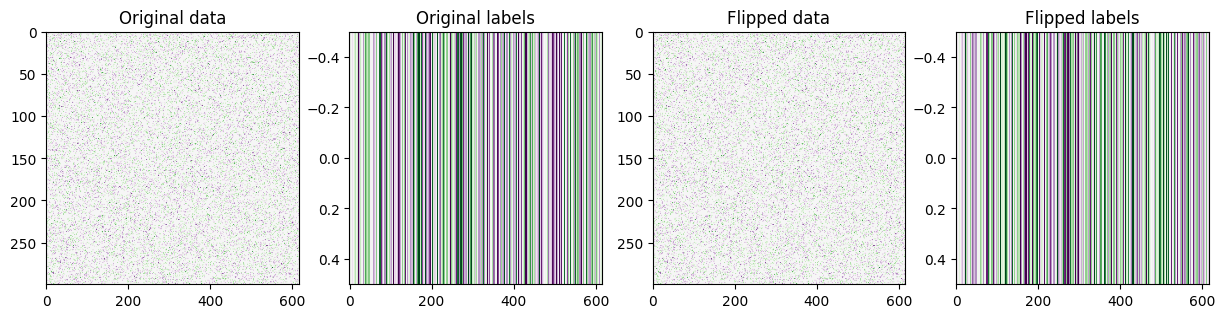

In [20]:
for i in range(1,5):
    print(train_labels[flip_idx[i]])
    print(train_labels_flipped[flip_idx[i]])
    print('----------')

# Plot training data and label
fig, axs = plt.subplots(1,4, figsize=(15,5))

im = axs[0].imshow(torch.t(train_data[flip_idx]), cmap='PRGn', aspect=train_data[flip_idx].shape[0]/train_data[flip_idx].shape[1])
# plt.colorbar(im)
axs[0].set_title('Original data')

im = axs[1].imshow(train_labels[flip_idx][None], cmap='PRGn', aspect=train_labels[flip_idx].shape[0])
# plt.colorbar(im)
axs[1].set_title('Original labels')

im = axs[2].imshow(torch.t(train_data[flip_idx]), cmap='PRGn', aspect=train_data[flip_idx].shape[0]/train_data[flip_idx].shape[1])
# plt.colorbar(im)
axs[2].set_title('Flipped data')

im = axs[3].imshow(train_labels_flipped[flip_idx][None], cmap='PRGn', aspect=train_labels_flipped[flip_idx].shape[0])
# plt.colorbar(im)
axs[3].set_title('Flipped labels')

Epoch [1/50], Step [25/1], Loss: 0.4923
Epoch [2/50], Step [25/1], Loss: 0.4755
Epoch [3/50], Step [25/1], Loss: 0.4574
Epoch [4/50], Step [25/1], Loss: 0.4363
Epoch [5/50], Step [25/1], Loss: 0.4137
Epoch [6/50], Step [25/1], Loss: 0.3905
Epoch [7/50], Step [25/1], Loss: 0.3682
Epoch [8/50], Step [25/1], Loss: 0.3477
Epoch [9/50], Step [25/1], Loss: 0.3294
Epoch [10/50], Step [25/1], Loss: 0.3134
Epoch [11/50], Step [25/1], Loss: 0.2996
Epoch [12/50], Step [25/1], Loss: 0.2877
Epoch [13/50], Step [25/1], Loss: 0.2776
Epoch [14/50], Step [25/1], Loss: 0.2690
Epoch [15/50], Step [25/1], Loss: 0.2615
Epoch [16/50], Step [25/1], Loss: 0.2551
Epoch [17/50], Step [25/1], Loss: 0.2495
Epoch [18/50], Step [25/1], Loss: 0.2446
Epoch [19/50], Step [25/1], Loss: 0.2403
Epoch [20/50], Step [25/1], Loss: 0.2365
Epoch [21/50], Step [25/1], Loss: 0.2332
Epoch [22/50], Step [25/1], Loss: 0.2301
Epoch [23/50], Step [25/1], Loss: 0.2274
Epoch [24/50], Step [25/1], Loss: 0.2250
Epoch [25/50], Step [25/1

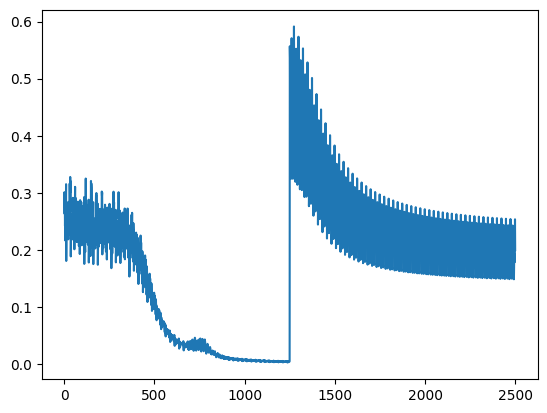

In [21]:
#@title Retrain co-release model
for epoch in range(num_epochs):
  for counter in range(max(1, math.floor(n_contexts/batch_size))):
    batch_range = range(counter*batch_size, counter*batch_size+batch_size)
    batch_data = train_data[batch_range,:]#.cuda()
    batch_labels = train_labels_flipped[batch_range]#.cuda()

    optimizer.zero_grad()
    outputs = net(batch_data)
    
    loss = loss_function(outputs.flatten(), batch_labels)
    training_loss.append(loss.data.cpu())

    loss.backward()
    optimizer.step()
    net.trimWeights()
    
  print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
              %(epoch+1, num_epochs, counter+1, len(batch_data)//batch_size, loss.data))
  scheduler.step()

plt.plot(training_loss)

Text(0.5, 1.0, 'Accuracy: 0.0000 %')

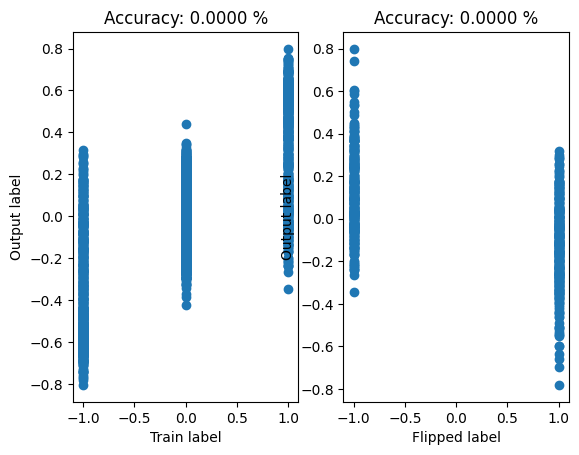

In [22]:
#@title Evaluating the accuracy of the model
with torch.no_grad():
  train_outputs = net(train_data)
  flipped_outputs = net(train_data[flip_idx,:])

  # Calculate accuracy
  train_accuracy = 100 * (torch.isclose(train_outputs.squeeze(), train_labels_flipped, rtol=1e-1)).sum() / train_labels.shape[0]
  flipped_accuracy = 100 * (torch.isclose(flipped_outputs.squeeze(), train_labels_flipped[flip_idx], rtol=1e-1)).sum() / test_labels.shape[0]

fig, axs = plt.subplots(1,2)

axs[0].plot(train_labels.flatten().cpu().numpy(), train_outputs.flatten().cpu().numpy(), 'o')
axs[0].set_xlabel('Train label')
axs[0].set_ylabel('Output label')
axs[0].set_title('Accuracy: %.4f %%' %(train_accuracy))

axs[1].plot(train_labels_flipped[flip_idx].flatten().cpu().numpy(), flipped_outputs.flatten().cpu().numpy(), 'o')
axs[1].set_xlabel('Flipped label')
axs[1].set_ylabel('Output label')
axs[1].set_title('Accuracy: %.4f %%' %(flipped_accuracy))

EP_to_LHb.weight
 Positive: 50.37999749183655%; Negative: 49.61999952793121%; Zero: 0.0%
EP_to_LHb.bias
 Positive: 56.00000023841858%; Negative: 43.99999976158142%; Zero: 0.0%
LHb_to_DAN.weight
 Positive: 0.0%; Negative: 68.99999976158142%; Zero: 31.00000023841858%
LHb_to_DAN.bias
 Positive: 0.0%; Negative: 100.0%; Zero: 0.0%


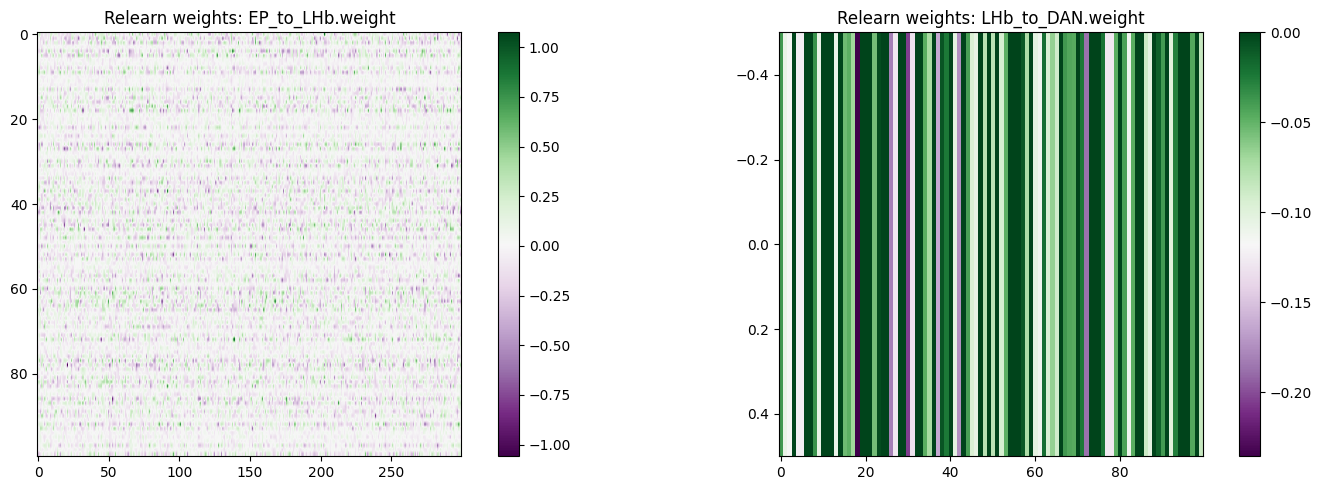

In [23]:
# Save the trianed parameters in paramList
relearn_params_corelease = {}
for name, param in net.named_parameters():
    if param.requires_grad:
      print(name)
      with torch.no_grad():
        cur_data = param.data.detach().cpu().clone()
        relearn_params_corelease[name] = (cur_data)
      
      frac_pos = 100*(torch.sum(cur_data > 0)/cur_data.numel()).numpy()
      frac_zero = 100*(torch.sum(cur_data == 0)/cur_data.numel()).numpy()
      frac_neg = 100*(torch.sum(cur_data < 0)/cur_data.numel()).numpy()
      print(' Positive: ' + str(frac_pos) + '%; Negative: ' + str(frac_neg) + '%; Zero: ' + str(frac_zero) + '%')

# Plot initialized weights
fig, axs = plt.subplots(1,int(len(initial_params_corelease)/2),figsize=(15, 5))
plt.subplots_adjust(hspace=0.5)

ax = 0
for key, value in relearn_params_corelease.items():
    if "bias" in key: continue
    im = axs[ax].imshow(value.numpy(), cmap='PRGn', aspect=value.shape[1]/value.shape[0])
    axs[ax].set_title('Relearn weights: ' + key)
    plt.colorbar(im)
    ax += 1

plt.tight_layout()
plt.show()

EP_to_LHb.weight flipped:  6.087% (1826/30000)
EP_to_LHb.bias flipped:  3.000% (3/100)
LHb_to_DAN.weight flipped:  0.000% (0/100)
LHb_to_DAN.bias flipped:  0.000% (0/1)
EP_to_LHb.weight changed:  100.000% (30000/30000)
EP_to_LHb.bias changed:  100.000% (100/100)
LHb_to_DAN.weight changed:  100.000% (100/100)
LHb_to_DAN.bias changed:  100.000% (1/1)


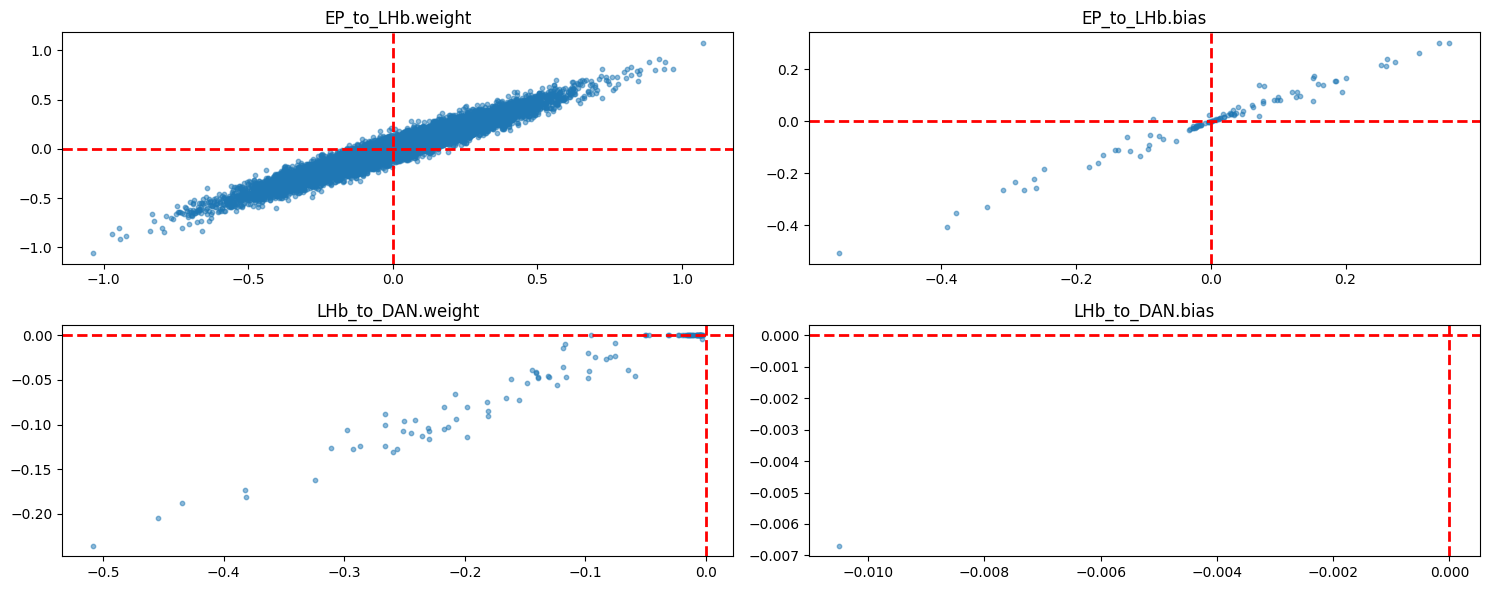

In [24]:
#@title What fraction of parameters flip sign?
for key in trained_params_corelease:
    n_weights=trained_params_corelease[key].numel()
    n_flip = (trained_params_corelease[key].sign()*relearn_params_corelease[key].sign()<0).count_nonzero().item()
    print(key + ' flipped: % .3f%% (%d/%d)' %(100*n_flip/n_weights, n_flip, n_weights))

for key in trained_params_corelease:
    n_weights=trained_params_corelease[key].numel()
    n_changed = (trained_params_corelease[key] != relearn_params_corelease[key]).count_nonzero().item()
    print(key + ' changed: % .3f%% (%d/%d)' %(100*n_changed/n_weights, n_changed, n_weights))

# Plot initial vs trained values
fig, axs = plt.subplots(2,int(len(relearn_params_corelease)/2),figsize=(15, 6))
plt.subplots_adjust(hspace=0.5)

ax = 0
for i, ax in enumerate(axs.flatten()):
    key = list(relearn_params_corelease)[i]
    ax.scatter(trained_params_corelease[key].numpy(),relearn_params_corelease[key].numpy(),s=10,alpha=0.5)
    ax.axhline(y=0, linewidth=2, color = 'r', ls='--')
    ax.axvline(x=0, linewidth=2, color = 'r', ls='--')
    ax.set_title(key)

plt.tight_layout()
plt.show()

In [25]:
plt.scatter(oldWeights, net.EP_to_LHB.weight.data.cpu().numpy())

NameError: name 'oldWeights' is not defined

In [ ]:
plotWithColor(net.EP_to_LHB.weight.data.cpu().numpy())
plotWithColor(net.LHB_to_DAN.weight.data.cpu().numpy())
#plt.plot(net.LHB_to_DAN.weight.data.cpu().flatten().numpy())


In [ ]:
training_labels_sort, indices = torch.sort(training_labels)
training_sort = training[indices,:]

In [ ]:
plotWithColor(torch.transpose(training_sort, 0, 1).cpu().numpy())
plt.plot(training_labels_sort.cpu().flatten().numpy())

In [ ]:
with torch.no_grad():
  LHB_act = net.EP_to_LHB(training_sort)
  LHB_out = net.relu(LHB_act)

  DAN_act = net.LHB_to_DAN(LHB_out)
  DAN_out = net.tanh(DAN_act)


In [ ]:
plotWithColor(torch.transpose(LHB_act.cpu().detach(), 0, 1).numpy())


In [ ]:
plotWithColor(torch.transpose(LHB_out.cpu().detach(), 0, 1).numpy())


In [ ]:
plt.plot(l1_act.cpu().numpy())

In [ ]:
plt.plot(l2_act_pos.cpu().numpy(), label='l2 act pos')
plt.plot(l2_act_neg.cpu().numpy(), label='l2 act neg')
plt.plot(l2_act.cpu().numpy(), label='l2 act')
plt.plot(l2_out.cpu().numpy(), label='l2 out')
plt.legend()

In [ ]:
#plt.plot(l1_out.cpu().numpy(), label='l1 out')
#plt.plot(l2_out.cpu().numpy(), label='l2 out')
plt.plot(neg_act.cpu().numpy(), label='neg out')
plt.plot(neg_out.cpu().numpy(), label='neg out')
plt.plot(out.cpu().numpy(), label='out')
plt.legend()



In [ ]:
probs = torch.nn.functional.softmax(out, dim=0)
plt.plot(probs.cpu().numpy())

In [ ]:
plt.plot(l1_out.cpu().numpy())
plt.plot(neg_out.cpu().numpy())
plt.plot(l2_act.cpu().numpy())
plt.plot(l2_out.cpu().numpy())


In [ ]:

fig, axs = plt.subplots(1, 10)
fig.set_figwidth(20)

for counter in range(10):
  axs[counter].imshow(images[counter, :].resize(28,28).cpu().numpy())

  # Hide X and Y axes label marks
  axs[counter].xaxis.set_tick_params(labelbottom=False)
  axs[counter].yaxis.set_tick_params(labelleft=False)

  # Hide X and Y axes tick marks
  axs[counter].set_xticks([])
  axs[counter].set_yticks([])



In [ ]:

fig, axs = plt.subplots(2, 10)
fig.set_figwidth(20)

for counter in range(10):
  axs[0, counter].imshow(net.input_to_l1.weight.data[counter,:].resize(28,28).cpu().numpy())

  # Hide X and Y axes label marks
  axs[0, counter].xaxis.set_tick_params(labelbottom=False)
  axs[0, counter].yaxis.set_tick_params(labelleft=False)

  # Hide X and Y axes tick marks
  axs[0, counter].set_xticks([])
  axs[0, counter].set_yticks([])

for counter in range(10):
  axs[1, counter].imshow(net.input_to_l1.weight.data[100+counter,:].resize(28,28).cpu().numpy())

  # Hide X and Y axes label marks
  axs[1, counter].xaxis.set_tick_params(labelbottom=False)
  axs[1, counter].yaxis.set_tick_params(labelleft=False)

  # Hide X and Y axes tick marks
  axs[1, counter].set_xticks([])
  axs[1, counter].set_yticks([])





In [ ]:

fig, axs = plt.subplots(2, 10)
fig.set_figwidth(20)

for counter in range(10):
  axs[0, counter].plot(net.l1_to_l2.weight.data[counter,:].cpu().numpy())
  axs[1, counter].plot(net.l1_to_neg.weight.data[counter,:].cpu().numpy())






In [ ]:
#@title Examine per label activations

with torch.no_grad():
  for label_to_examine in range(0,10):
    correct = 0
    total = 0
    for images,labels in test_gen:
      images = images.view(-1,28*28).cuda()
      labels = labels.cuda()

      indices=torch.where(labels==label_to_examine)[0]
      if indices.nelement()!=0:
        output = net(images[indices])
        _, predicted = torch.max(output,1)
        correct += (predicted == labels[indices]).sum()
        total += indices.nelement()
    print(label_to_examine)
    print('   Accuracy of the model: %.3f %%' %((100*correct)/(total+1)))

In [ ]:
#@title Function to keep sum of parameters

def sumNetParams(firstPass, paramList):
  if firstPass:
    paramList.clear()
    paramList.append(0)
    paramCounter=1
  else:
    paramList[0]+=1

  paramCounter=1
  for name, param in net.named_parameters():
    if param.requires_grad:
      if firstPass:
        print(paramCounter, name)
        paramList.append(param.data)
      else:
        paramList[paramCounter]=paramList[paramCounter]+param.data
    paramCounter+=1


In [ ]:
#@title Average activations per label
firstPass=True
paramList=[0]

with torch.no_grad():
  label_to_examine=0
  correct = 0
  total = 0
  for images,labels in test_gen:
    images = images.view(-1,28*28).cuda()
    labels = labels.cuda()

    indices=torch.where(labels==label_to_examine)[0]
    if indices.nelement()!=0:
      output = net(images[indices])
      _, predicted = torch.max(output,1)
      correct += (predicted == labels[indices]).sum()
      total += indices.nelement()
      sumNetParams(firstPass, paramList)
      firstPass=False

  print(label_to_examine)
  print('   Accuracy of the model: %.3f %%' %((100*correct)/(total+1)))

In [ ]:
#@title Average activations per label
firstPass=True
paramList=[0]

with torch.no_grad():
  label_to_examine=1
  correct = 0
  total = 0
  for images,labels in test_gen:
    images = images.view(-1,28*28).cuda()
    labels = labels.cuda()

    indices=torch.where(labels==label_to_examine)[0]
    if indices.nelement()!=0:
      total += indices.nelement()

      with torch.no_grad():
          input=images[indices]
          l1_act = net.input_to_l1(input)
          l1_out = net.relu(l1_act)

          neg_act = net.l1_to_neg(l1_out)
          neg_out = net.relu(neg_act)

          l2_act_pos = net.l1_to_l2(l1_out)
          l2_act_neg = net.neg_l2(neg_out)
          l2_act = l2_act_pos + l2_act_neg
          l2_out = net.relu(l2_act)

          out = net.l2_to_out(l2_out)

          if firstPass:
            paramList=[0, l1_act.mean(0), l1_out.mean(0), neg_act.mean(0), neg_out.mean(0), l2_act_pos.mean(0), l2_act_neg.mean(0), l2_act.mean(0), l2_out.mean(0), out.mean(0)]
            firstPass=False
          else:
            paramList[0]+=1
            paramList[1]+=l1_act.mean(0)
            paramList[2]+=l1_out.mean(0)
            paramList[3]+=neg_act.mean(0)
            paramList[4]+=neg_out.mean(0)
            paramList[5]+=l2_act_pos.mean(0)
            paramList[6]+=l2_act_neg.mean(0)
            paramList[7]+=l2_act.mean(0)
            paramList[8]+=l2_out.mean(0)
            paramList[9]+=out.mean(0)

for counter in range(1, 10):
  paramList[counter]/=paramList[0]

In [ ]:
plt.figure(figsize=(20,2))
for counter in range(1, 10):
  plt.subplot(1, 10, counter)
  plt.plot(paramList[counter].cpu().numpy())

In [ ]:

fig, axs = plt.subplots(2, 10)
fig.set_figwidth(20)

for counter in range(10):
  axs[0, counter].plot(net.fc2.weight.data[:,counter].cpu().numpy())
  axs[1, counter].plot(net.fc2.weight.data[:,100+counter].cpu().numpy())

In [ ]:
fc1_input_mean= [ torch.mean(net.fc1.weight.data[counter,:]).item() for counter in range(hidden_size) ]
fc1_input_var= [ torch.var(net.fc1.weight.data[counter]).item() for counter in range(hidden_size) ]
fc2_output_mean= [ torch.mean(net.fc2.weight.data[:,counter]).item() for counter in range(hidden_size) ]
fc2_output_var= [ torch.var(net.fc2.weight.data[:,counter]).item() for counter in range(hidden_size) ]
fcOut_input_mean= [ torch.mean(net.fc2.weight.data[counter, :]).item() for counter in range(hidden_size2) ]
fcOut_input_var= [ torch.var(net.fc2.weight.data[counter, :]).item() for counter in range(hidden_size2) ]
fc2_bias=net.fc2.bias.data.cpu().numpy()
fc1_bias=net.fc1.bias.data.cpu().numpy()

In [ ]:
plt.scatter(fc1_input_mean,fc1_input_var)
net.fc1.weight.data.size()

In [ ]:
plt.scatter(fcOut_input_mean,fcOut_input_var)


In [ ]:
plt.plot(fc1_bias)
